# Fed-Batch Bioreactor

Batch reactors are commonly used in the production of speciality chemicals, pharmaceuticals, and beverage and food products. 

![](https://live.staticflickr.com/5129/5283264793_973c8f0bea_c.jpg)
<br>Source: Sanofi Pasteur, Creative Commons License

The following links provide additional illustrations of fed-batch fermentation:

* https://ib.bioninja.com.au/_Media/penicillin-production-2_med.jpeg
* https://biologyreader.com/wp-content/uploads/2021/07/diagram-of-fed-batch-culture.jpg

Our goal is to demonstrate modeling of a fed-batch fermentation process. The learning goals are:

* Learn to develop models for reactive systems using mass balances.
* Model variable volume dilution effects.
* Simulate the response of the model using Python solvers for initial value problems.

## Modeling Tank Volume

The volumetric inlet flowrate to a fed-batch reactor is $F(t)$. Assuming changes in specific volume due to mixing, the volume of liquid in the reactor is given by

$$\frac{dV}{dt} = F(t)$$

Assume the initial volume is 1 liter and a constant flowrate of 0.05 liters/hour. Simulate the volume of the reactor for 50 hours.

<AxesSubplot:xlabel='Time'>

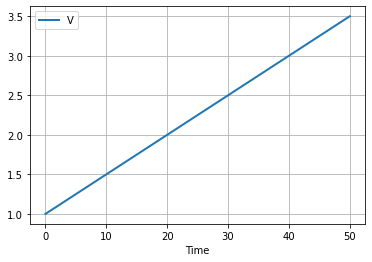

In [12]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# inlet flowrate
def F(t):
    return 0.05

# differential equations
def deriv(t, y):
    dV = F(t)
    return [dV]

# initial conditions
IC = [1.0]

# integration period
t_final = 50

# solve ivp
soln = solve_ivp(deriv, [0, t_final], IC, max_step=1.0)

# extract solution into a data frame
df = pd.DataFrame(soln.y.T, columns=["V"])
df["Time"] = soln.t

# plot
df.plot(x = "Time", grid=True, lw=2)

## Modeling Substrate Composition

The feed entering the tank carries important nutrients for the fermentation. Assume the substrate feed composition $S_f$ is 10 grams/liter. Simulate the concentration in the fed-batch reactor.

$$\frac{d(VS)}{dt} = F S_f$$

Applying the chain rule

$$\frac{d(VS)}{dt} = V\frac{dS}{dt} + S\frac{dV}{dt}$$

so the mass balance becomes

$$
\begin{align*}
& V\frac{dS}{dt} + S\frac{dV}{dt} = F S_f \\
\implies &  V\frac{dS}{dT} + S F = F S_f \\
\implies & V\frac{dS}{dt} = F (S_f - S) \\
\implies & \frac{dS}{dt} = \frac{F}{V} (S_f - S)\\
\end{align*}
$$

which accounts for dilution due to changing tank volume. The model now has state variables for substrate composition and tank volume.

$$
\begin{align*}
\frac{dS}{dt} & = \frac{F(t)}{V} (S_f - S) \\
\frac{dV}{dt} &  = F(t)
\end{align*}
$$

The following cell extends our simulation model to include substrate concentration.

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

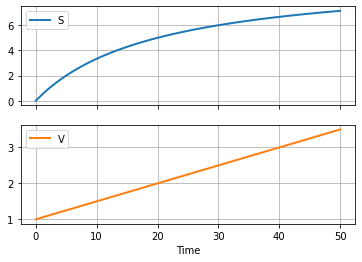

In [11]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# parameter values
Sf = 10.0         # g/liter

# inlet flowrate
def F(t):
    return 0.05

# differential equations
def deriv(t, y):
    S, V = y
    dS = F(t)*(Sf - S)/V
    dV = F(t)
    return [dS, dV]

# initial conditions
IC = [0.0, 1.0]

# integration period
t_final = 50

# solve ivp
soln = solve_ivp(deriv, [0, t_final], IC, max_step=1.0)

# extract solution into a data frame
df = pd.DataFrame(soln.y.T, columns=["S", "V"])
df["Time"] = soln.t

# plot
df.plot(x = "Time", grid=True, lw=2, subplots=True)

## Modeling Biomass

Fermentation is process in which biomass consumes substrate to produce more biomass and by-products.

$$\text{Biomass (X)} + \frac{1}{Y_{X/S}}\text{Substrate (S)} \stackrel{r_g(X, S)}{\longrightarrow} \text{Biomass (X)} + Y_{P/X}\text{Products (P)}$$

The rate $r_g(X,S)$ is the production of fresh cell biomass in units of grams/liter/hr. The volume specific growth rate is expressed as

$$r_g(X,S) = \mu(S)X$$

where $\mu(S)$ is the cell specific growth rate. In the Monod model, the cell specific growth rate is a function of substrate concentration given by

$$\mu(S) = \mu_{max}\frac{S}{K_S + S}$$

where $\mu_{max}$ is the maximum specific growth rate, and $K_S$ is the saturation constant. $K_S$ is equal to the value of $S$ for which $\mu = \frac{1}{2}\mu_{max}$.

The overall balance for biomass is

$$\frac{d(VX)}{dt} = V r_g(X, S)$$

After accounting for the dilution effect our model becomes

$$
\begin{align*}
\frac{dX}{dt} & = - \frac{F(t)}{V} X +  r_g(X, S) \\
\frac{dS}{dt} & = \frac{F(t)}{V} (S_f - S) \\
\frac{dV}{dt} &  = F(t)
\end{align*}
$$

The following cell shows the results of incorporating biomass growth into the model for the fed-batch reaction.

array([<AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>], dtype=object)

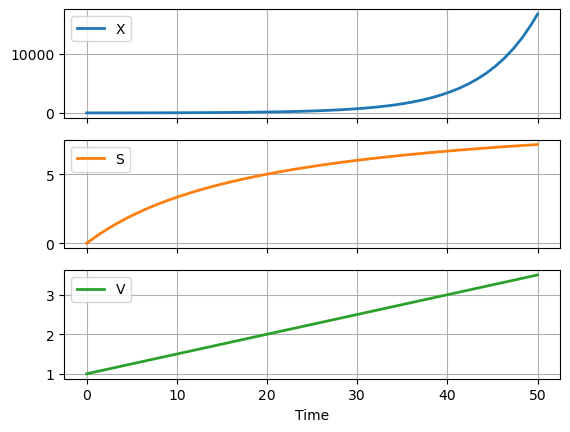

In [4]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# parameter values
Sf = 10.0         # g/liter
mumax = 0.20      # 1/hour
Ks = 1.00         # g/liter

# inlet flowrate
def F(t):
    return 0.05

# reaction rates
def mu(S):
    return mumax*S/(Ks + S)

def Rg(X, S):
    return mu(S)*X

# differential equations
def deriv(t, y):
    X, S, V = y
    dX = -F(t)*X/V + Rg(X, S)
    dS = F(t)*(Sf - S)/V
    dV = F(t)
    return [dX, dS, dV]

# initial conditions
IC = [20.0, 0.0, 1.0]

# integration period
t_final = 50

# solve ivp
soln = solve_ivp(deriv, [0, t_final], IC, max_step=1.0)

# extract solution into a data frame
df = pd.DataFrame(soln.y.T, columns=["X", "S", "V"])
df["Time"] = soln.t

# plot
df.plot(x = "Time", grid=True, lw=2, subplots=True)

:::{admonition} Experiment with this model

At this stage the model is not complete and will give implausible simulation results. But is still important to understand what the model is doing and why the simulation results do provide the results you may expect.

Before going further with this notebook, run this notebook and experiment with different initial conditions for $X$. Choose small values and see what happens. Why are the results different than one might expect of a fed-batch bioreactor?

:::

### Substrate Modeling, revisited

The growth of biomass consumes substrate which serves to limit the production of biomass.  Assume the substrate is consumed is proportion to the mass of new cells formed where $Y_{X/S}$ is the yield coefficient for new cells.

$$Y_{X/S} = \frac{\text{mass~of~new~cells~formed}}{\text{mass~of~substrate~consumed}} ~.$$

where $\mu(S)$ is the cell specific growth rate. So the total consumption of substrate becomes

$$\frac{V}{Y_{X/S}} r_g(X, S)$$

Including this in our model

$$
\begin{align*}
\frac{dX}{dt} & = - \frac{F(t)}{V} X +  r_g(X, S) \\
\frac{dS}{dt} & = \frac{F(t)}{V} (S_f - S) - \frac{1}{Y_{X/S}}r_g(X,S) \\
\frac{dV}{dt} &  = F(t)
\end{align*}
$$

array([<AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>], dtype=object)

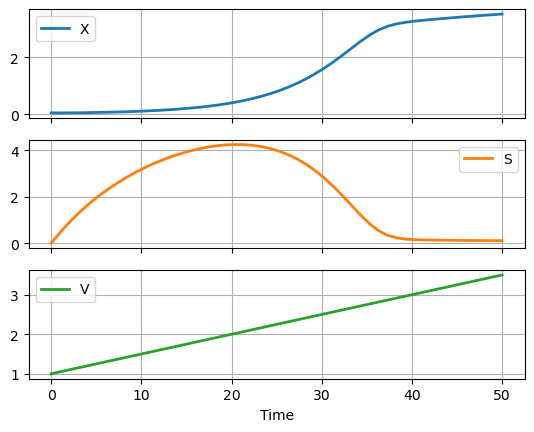

In [5]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# parameter values
Sf = 10.0         # g/liter
mumax = 0.20      # 1/hour
Ks = 1.00         # g/liter
Yxs = 0.5         # g/g

# inlet flowrate
def F(t):
    return 0.05

# reaction rates
def mu(S):
    return mumax*S/(Ks + S)

def Rg(X,S):
    return mu(S)*X

# differential equations
def deriv(t, y):
    X, S, V = y
    dX = -F(t)*X/V + Rg(X, S)
    dS = F(t)*(Sf - S)/V - Rg(X,S)/Yxs
    dV = F(t)
    return [dX, dS, dV]

# initial conditions
IC = [0.05, 0.0, 1.0]

# integration period
t_final = 50

# solve ivp
soln = solve_ivp(deriv, [0, t_final], IC, max_step=1.0)

# extract solution into a data frame
df = pd.DataFrame(soln.y.T, columns=["X", "S", "V"])
df["Time"] = soln.t

# plot
df.plot(x = "Time", grid=True, lw=2, subplots=True)

### Product Modeling

At this stage this is just one last consideration, modeling of the product produced by the fed-batch fermenter. For this model, the product is assumed to be a by-product of cell growth

$$r_P(X,S) = Y_{P/X}r_g(X,S)$$

where $Y_{P/X}$ is the product yield coefficient defined as

$$Y_{P/X} = \frac{\text{mass~of~product~formed}}{\text{mass~of~new~cells~formed}} ~.$$

The mass balance for product is given by

$$\frac{d(VP)}{dt} =  r_P(X,S)$$

Applying the chain rule for derivatives results in the final version of our model.

$$\begin{align*}
\frac{dX}{dt} & = - \frac{F(t)}{V}X + r_g(X,S)  \\
\frac{dP}{dt} & = - \frac{F(t)}{V}P + r_P(X,S) \\
\frac{dS}{dt} & = \frac{F(t)}{V}(S_f - S) - \frac{1}{Y_{X/S}}r_g(X,S) \\
\frac{dV}{dt} & = F(t)
\end{align*}$$

array([<AxesSubplot: title={'center': 'Biomass (X)'}, xlabel='Time'>,
       <AxesSubplot: title={'center': 'Product (P)'}, xlabel='Time'>,
       <AxesSubplot: title={'center': 'Substrate (S)'}, xlabel='Time'>,
       <AxesSubplot: title={'center': 'Volume (V)'}, xlabel='Time'>],
      dtype=object)

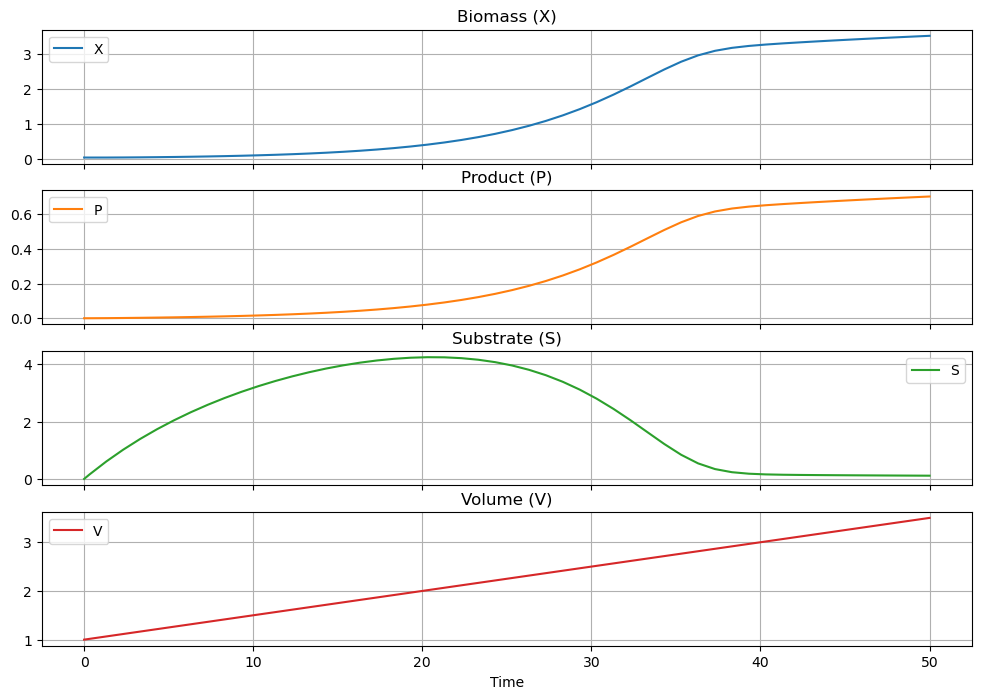

In [9]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# parameter values
mumax = 0.20      # 1/hour
Ks = 1.00         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.2         # g/g
Sf = 10.0         # g/liter

# inlet flowrate
def F(t):
    return 0.05

# reaction rates
def mu(S):
    return mumax*S/(Ks + S)

def Rg(X,S):
    return mu(S)*X
    
def Rp(X,S):
    return Ypx*Rg(X,S)

# differential equations
def deriv(t, y):
    X, P, S, V = y
    dX = -F(t)*X/V + Rg(X,S)
    dP = -F(t)*P/V + Rp(X,S)
    dS = F(t)*(Sf - S)/V - Rg(X,S)/Yxs
    dV = F(t)
    return [dX, dP, dS, dV]

IC = [0.05, 0.0, 0, 1.0]
t_final = 50

soln = solve_ivp(deriv, [0, t_final], IC, max_step=1.0)
df = pd.DataFrame(soln.y.T, columns=["X", "P", "S", "V"])
df["Time"] = soln.t

df.plot(x = "Time", grid=True, subplots=True, figsize=(12, 8),
       title=["Biomass (X)", "Product (P)", "Substrate (S)", "Volume (V)"], sharex=True)

## Exercises: Putting the Simulation Model to Work

Simulation has many uses, among them is to gain insight into operating strategies. 

:::{admonition} Exercise 1

The above simulations have been run with initial conditions $X_0$ = 0.05 g/liter, $V$ = 1 liter, and $P_0$ = $S_0$ = 0 g/liter. Suppose the economic operation of the downstream separations process require a product concentration $P$ of at least 0.8 g/liter. How long would you have to operate the reactor?  (Hint: Modify the simulation to create a terminal event corresponding to the desired product concentration. See Section 2.2 for an example, or consult the documentation for `scipy.integrate.solve_ivp` to see how this is done.)

:::

:::{admonition} Exercise 2

One problem with the operation is that the initial load of the bioreactor has no substrate. Suppose we change the operating strategy to set the initial substrate concentration equal to the feed concentration $S_0 = S_f$.  Now how long does it take to get to a product concentration $P$ = 0.8 g/liter?

:::

:::{admonition} Exercise 3

We know now have decided to operate the bioreactor with an initial substrate concentration $S_0$ = $S_f$. Now we need to decide how long to run the reactor before shutting down, cleaning, and restarting with a new batch. Assume the turn around time is 4 hours, and productivity is measured as 

$$\text{Productivity} = \frac{P \cdot V}{t_{turn-around} + t}$$ 

where $t$ is time since start of the batch. Modify the dataframe to compute productivity as a function of $t$, and decide the optimal time to run the batch.

:::

**Solution (tag: remove-cell):**

The straightforward solution to this problem is add a column to the dataframe of simulation results, plot as a function of t, then lookup and report the time at which Productivity is a maximum. This is about 33 hours.

Another way to solve this problem is to create a new differential equation 

$$
\begin{align*}
\frac{d}{dt}\text{Productivity} & = \frac{P'V + P V'}{t_{turnaround} + t} - \frac{PV}{(t_{turnaround} + t)^2}
\end{align*}
$$

and set up an event to determine when the rate of change is zero.

Maximum productivity reached at t = [array([33.60731468])]


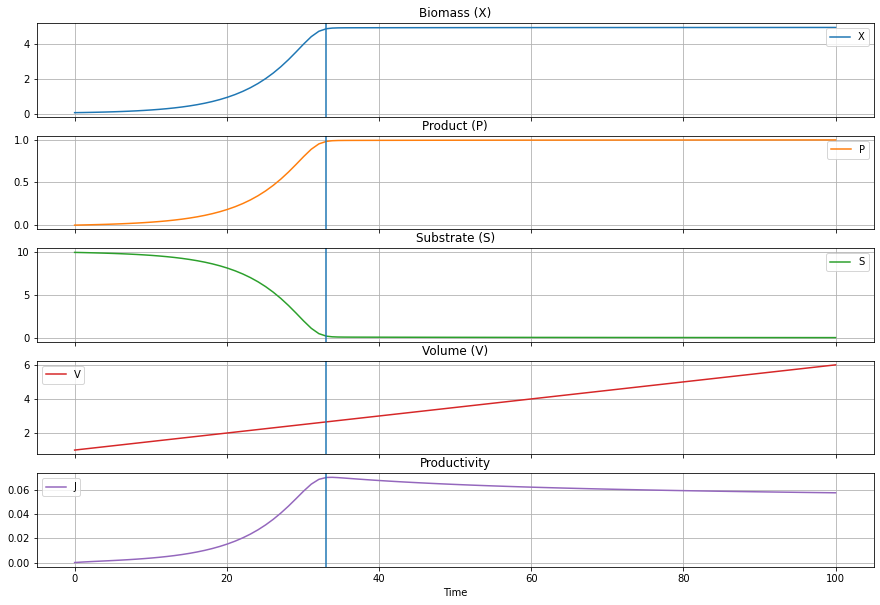

In [14]:
# tagged: remove-cell
# Plot a column to the dataframe to plot productivity versus time.

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# parameter values
mumax = 0.20      # 1/hour
Ks = 1.00         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.2         # g/g
Sf = 10.0         # g/liter
t_turnaound = 4   # hr

# inlet flowrate
def F(t):
    return 0.05

# reaction rates
def mu(S):
    return mumax*S/(Ks + S)

def Rg(X,S):
    return mu(S)*X
    
def Rp(X,S):
    return Ypx*Rg(X,S)

def Productivity_max(t, y):
    dy = deriv(t, y)
    return dy[-1]

# differential equations
def deriv(t, y):
    X, P, S, V, J = y
    dX = -F(t)*X/V + Rg(X,S)
    dP = -F(t)*P/V + Rp(X,S)
    dS = F(t)*(Sf - S)/V - Rg(X,S)/Yxs
    dV = F(t)
    dJ = (P*dV + V*dP)/(t_turnaround + t) - P*V/(t_turnaround + t)**2
    return [dX, dP, dS, dV, dJ]

IC = [0.05, 0.0, Sf, 1.0, 0.0]
t_final = 100

soln = solve_ivp(deriv, [0, t_final], IC, max_step=1.0, events=[Productivity_max])
t_events = soln.t_events
print(f"Maximum productivity reached at t = {t_events}")

df = pd.DataFrame(soln.y.T, columns=["X", "P", "S", "V", "J"])
df["Time"] = soln.t

#df["Productivity"] = df["P"]*df["V"]/(t_turnaround + df["Time"])

ax = df.plot(x = "Time", grid=True, subplots=True, figsize=(15, 10), sharex=True,
        title=["Biomass (X)", "Product (P)", "Substrate (S)", "Volume (V)", "Productivity"])

import matplotlib.pyplot as plt
for a in ax:
    a.axvline(33)